### Seguridad Ecopetrol

## Contenido
* Importación librerías
* Carga información
* Calculo General
* Series de tiempo
 * ITEM
 * DES_ACCION
* Preciciones
* Revisión Metricas
* Seleccion Mejor Método
* Predicciones futuras

## Importación Librerías

In [30]:
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, date, timedelta
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings('ignore')

## Carga información

In [31]:
path_data = ''
#file= f'VW_TRAF_SEGURIDAD_SEMANA_202109220849.csv'
file= f'VW_TRAF_SEGURIDAD_SEMANA_202110111532.csv'
df = pd.read_csv(f'{path_data}{file}', sep='|', decimal='.')

In [32]:
df.head()

,FEC_MUESTRA,DES_EVENTO,EQUIPO,DES_EQUIPO,DES_TIPO,DES_ACCION,ITEM,IP,THREAT,VAL_CANTIDAD,VAL_PORCENTAJE
0,2021-10-06 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,Phishing,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,17,0
1,2021-10-06 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,BEC,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,10,0
2,2021-10-06 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,facturacionsalud@ecopetrol.com.co,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,29631,0
3,2021-10-06 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,_helpdesk1@ecopetrol.com.co,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,9918,0
4,2021-10-06 00:00:00,SIN EVENTO,SIN EQUIPO,SIN DES_EQUIPO,facturaelectronica@ecopetrol.com.co,SIN ACCION,SIN ITEN,SIN IP,SIN THREAT,7412,0


In [33]:
len(df)

1128

##  Cálculo General

In [34]:
dfTotalV2=df.groupby(['FEC_MUESTRA'])[['VAL_CANTIDAD']].agg('sum')
dfTotalV2.index=pd.to_datetime(dfTotalV2.index)

In [35]:
dfTotalV2

,VAL_CANTIDAD
FEC_MUESTRA,
2021-06-30,464957
2021-07-07,420028
2021-07-14,525282
2021-07-21,481735
2021-08-11,984145
2021-08-18,926233
2021-08-25,928288
2021-09-01,888432
2021-09-08,1445879


<AxesSubplot:xlabel='FEC_MUESTRA'>

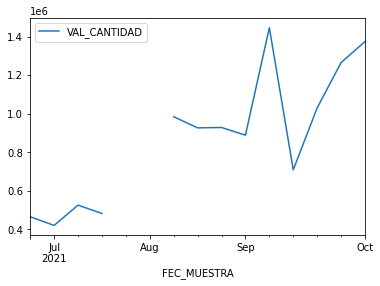

In [36]:
dfTotalV2.asfreq(freq='W-WED').plot()

<AxesSubplot:xlabel='FEC_MUESTRA'>

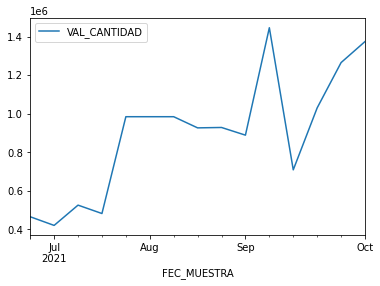

In [37]:
dfTotalV2.asfreq(freq='W-WED',method='bfill').plot()

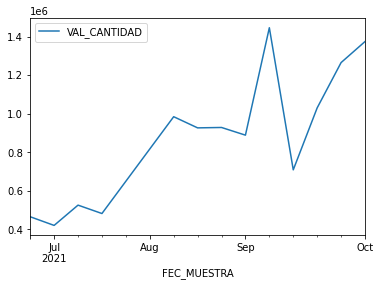

In [38]:
dfTotalV2.asfreq(freq='W-WED').interpolate().plot()
dfTotalV2=dfTotalV2.asfreq(freq='W-WED').interpolate()

### Seleccion Fecha Train y Test

In [43]:
fechaMaxima=max(dfTotalV2.index)
fechaMaxima

Timestamp('2021-10-06 00:00:00', freq='W-WED')

In [46]:
fechaMaxTrain=dfTotalV2.index[-5]
fechaMinTest=dfTotalV2.index[-4]

In [47]:
df_serie_train=dfTotalV2[:fechaMaxTrain]
df_serie_test=dfTotalV2[fechaMinTest:]

In [48]:
df_serie_test

,VAL_CANTIDAD
FEC_MUESTRA,
2021-09-15,708444.000
2021-09-22,1029954.000
2021-09-29,1265001.000
2021-10-06,1374144.000


In [49]:
ind = pd.date_range(df_serie_test.index.min(), periods = 4, freq ='W-WED', name='FEC_MUESTRA')

In [50]:
modelAutoARIMA=auto_arima(df_serie_train['VAL_CANTIDAD'], max_p = 4, max_q = 4,trace=False)
P_ModeloAUtoArima=pd.DataFrame(modelAutoARIMA.predict(n_periods = 4), index=ind)

In [51]:
dfTotalV2['p_ARIMA']=P_ModeloAUtoArima

In [52]:
## Exponential smooth
modelSM = SimpleExpSmoothing(df_serie_train['VAL_CANTIDAD'])
modelSM._index=df_serie_train.index

In [53]:
#P_ModeloAUtoArima
P_modelSM=modelSM.fit(smoothing_level=.5).forecast(5)
P_modelSM

2021-09-15   1171340.084
2021-09-22   1171340.084
2021-09-29   1171340.084
2021-10-06   1171340.084
2021-10-13   1171340.084
Freq: W-WED, dtype: float64

In [54]:
dfTotalV2['p_ES']=P_modelSM

In [55]:
## Holt

In [56]:
modelHl = Holt(df_serie_train['VAL_CANTIDAD'])
modelHl._index=df_serie_train.index

In [57]:
P_modelHl=modelHl.fit(optimized=True).forecast(5)
P_modelHl

2021-09-15   1347764.393
2021-09-22   1470672.478
2021-09-29   1593580.563
2021-10-06   1716488.648
2021-10-13   1839396.733
Freq: W-WED, dtype: float64

In [58]:
dfTotalV2['p_HL']=P_modelHl

In [59]:
modelESD=ExponentialSmoothing(df_serie_train['VAL_CANTIDAD'], trend='mul', seasonal=None, damped=True)
P_modelESD=modelESD.fit().forecast(5)

In [60]:
P_modelESD

2021-09-15   1424060.300
2021-09-22   1599124.947
2021-09-29   1793630.075
2021-10-06   2009485.382
2021-10-13   2248761.026
Freq: W-WED, dtype: float64

In [61]:
dfTotalV2['p_ESD']=P_modelESD

<AxesSubplot:xlabel='FEC_MUESTRA'>

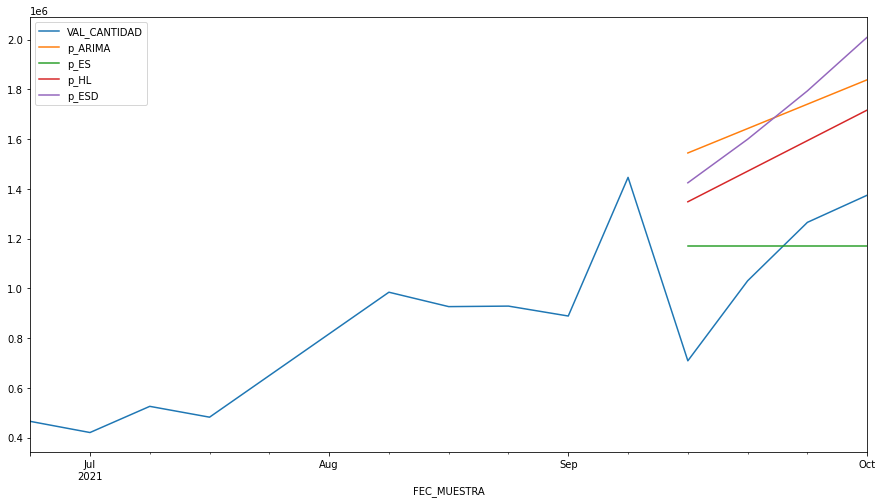

In [62]:
dfTotalV2.reset_index().plot('FEC_MUESTRA',['VAL_CANTIDAD','p_ARIMA','p_ES','p_HL','p_ESD'], figsize=(15,8))

## 2.  Des_Evento

In [86]:
dfDesEvento=df.groupby(['FEC_MUESTRA','DES_EVENTO'])['VAL_CANTIDAD'].agg('sum').reset_index('DES_EVENTO')

In [87]:
dfDesEvento

,DES_EVENTO,VAL_CANTIDAD
FEC_MUESTRA,,
2021-06-30 00:00:00,IPS_FORTINET,29
2021-06-30 00:00:00,SIN EVENTO,342881
2021-06-30 00:00:00,Top 10 Equipos C&c,17635
2021-06-30 00:00:00,Top 10 Equipos Malware,1077
2021-06-30 00:00:00,Top 10 Eventos C&c,101761
...,...,...
2021-10-06 00:00:00,Top 10 Equipos C&c,66556
2021-10-06 00:00:00,Top 10 Equipos Malware,69
2021-10-06 00:00:00,Top 10 Eventos C&c,589544


In [88]:
## agregar ITEM Malware y DES Accion Bloqueo
df_Accion=df[df['DES_ACCION']=='Bloqueos'].groupby(['FEC_MUESTRA'])[['VAL_CANTIDAD']].agg('sum')
df_Accion.columns=['ACCION_Bloqueos']

In [89]:
df_Accion

,ACCION_Bloqueos
FEC_MUESTRA,
2021-07-07 00:00:00,453
2021-07-14 00:00:00,510
2021-07-21 00:00:00,497
2021-08-11 00:00:00,760
2021-08-18 00:00:00,516
2021-08-25 00:00:00,593
2021-09-01 00:00:00,758
2021-09-08 00:00:00,756
2021-09-15 00:00:00,1022


In [90]:
df_Item=df[df['ITEM']=='Malware'].groupby(['FEC_MUESTRA'])[['VAL_CANTIDAD']].agg('sum')
df_Item.columns=['ITEM_Malware']

In [91]:
df_Item

,ITEM_Malware
FEC_MUESTRA,
2021-06-30 00:00:00,29
2021-07-14 00:00:00,27
2021-07-21 00:00:00,28
2021-08-11 00:00:00,10
2021-08-25 00:00:00,15
2021-09-01 00:00:00,20
2021-09-08 00:00:00,12
2021-09-15 00:00:00,119
2021-09-22 00:00:00,80


In [92]:
dfDesEvento_T=pd.pivot_table(dfDesEvento.reset_index(), index='FEC_MUESTRA', columns='DES_EVENTO', values='VAL_CANTIDAD')

In [93]:
dfDesEvento_T['ACCION_Bloqueos']=df_Accion['ACCION_Bloqueos']
dfDesEvento_T['ITEM_Malware']=df_Item['ITEM_Malware']

In [94]:
dfDesEvento_T

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30 00:00:00,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,NaN,29.000
2021-07-07 00:00:00,NaN,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,NaN
2021-07-14 00:00:00,27.000,352835.000,NaN,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21 00:00:00,28.000,323082.000,NaN,245.000,157856.000,459.000,65.000,497.000,28.000
2021-08-11 00:00:00,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18 00:00:00,NaN,757370.000,17927.000,NaN,150511.000,348.000,77.000,516.000,NaN
2021-08-25 00:00:00,15.000,722115.000,27825.000,NaN,176998.000,1162.000,173.000,593.000,15.000
2021-09-01 00:00:00,20.000,719624.000,30467.000,NaN,138210.000,NaN,111.000,758.000,20.000
2021-09-08 00:00:00,12.000,1291229.000,NaN,NaN,153972.000,646.000,20.000,756.000,12.000


In [95]:
dfDesEvento_T.index=pd.to_datetime(dfDesEvento_T.index)

In [96]:
dfDesEvento_T=dfDesEvento_T.asfreq(freq='W-WED').interpolate()
dfDesEvento_T.fillna(method="bfill",inplace=True)

In [97]:
dfDesEvento_T

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000


In [98]:
de_serie_train=dfDesEvento_T[:fechaMaxTrain]
de_serie_test=dfDesEvento_T[fechaMinTest:]
grupos=dfDesEvento_T.columns

In [99]:
grupos

Index(['IPS_FORTINET', 'SIN EVENTO', 'Top 10 Equipos C&c',
       'Top 10 Equipos Malware', 'Top 10 Eventos C&c',
       'Top 10 Eventos Malware', 'Top 10 Eventos Spyware', 'ACCION_Bloqueos',
       'ITEM_Malware'],
      dtype='object', name='DES_EVENTO')

In [100]:
de_serie_train

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000


In [101]:
prefix=['P_ARIMA_','p_ES_','p_HL_','p_ESD_']

In [102]:
M_error={}
for col in grupos: 
    M={}
    #model AutoARIMA
    modelAutoARIMA=auto_arima(de_serie_train[col],trace=False)
    modelAutoARIMA.fit(de_serie_train[col])
    P_ModeloAUtoArima=pd.DataFrame(modelAutoARIMA.predict(n_periods = 4), index=ind)
    dfDesEvento_T['P_ARIMA_'+col]=P_ModeloAUtoArima
    # model Exponential Smooting
    modelSM = SimpleExpSmoothing(de_serie_train[col])
    #modelSM._index=df_serie_train.index
    P_modelSM=modelSM.fit(smoothing_level=.5).forecast(4)
    dfDesEvento_T['p_ES_'+col]=P_modelSM
    #Holt
    modelHl = Holt(de_serie_train[col])
    P_modelHl=modelHl.fit(optimized=True).forecast(4)    
    dfDesEvento_T['p_HL_'+col]=P_modelHl
    #ES tend
    modelESD=ExponentialSmoothing(de_serie_train[col], trend='mul', seasonal=None, damped=True)
    P_modelESD=modelESD.fit().forecast(4)
    dfDesEvento_T['p_ESD_'+col]=P_modelESD
    ## calculo de errores
    M['RMSE_ARIMA']=mean_squared_error(de_serie_test[col],P_ModeloAUtoArima, squared=False)
    M['MAPE_ARIMA']=mean_absolute_percentage_error(de_serie_test[col],P_ModeloAUtoArima)
    M['RMSE_ES']=mean_squared_error(de_serie_test[col],P_modelSM, squared=False)
    M['MAPE_ES']=mean_absolute_percentage_error(de_serie_test[col],P_modelSM)
    M['RMSE_HL']=mean_squared_error(de_serie_test[col],P_modelHl, squared=False)
    M['MAPE_HL']=mean_absolute_percentage_error(de_serie_test[col],P_modelHl)
    M['RMSE_ESD']=mean_squared_error(de_serie_test[col],P_modelESD, squared=False)
    M['MAPE_ESD']=mean_absolute_percentage_error(de_serie_test[col],P_modelESD)
    M_error[col]=M

In [134]:
dfDesEvento_T

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware,P_ARIMA_IPS_FORTINET,...,p_HL_Top 10 Eventos Spyware,p_ESD_Top 10 Eventos Spyware,P_ARIMA_ACCION_Bloqueos,p_ES_ACCION_Bloqueos,p_HL_ACCION_Bloqueos,p_ESD_ACCION_Bloqueos,P_ARIMA_ITEM_Malware,p_ES_ITEM_Malware,p_HL_ITEM_Malware,p_ESD_ITEM_Malware
FEC_MUESTRA,,,,,,,,,,,,,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
M_error

{'IPS_FORTINET': {'RMSE_ARIMA': 62.02412277981434,
  'MAPE_ARIMA': 0.6434807213568339,
  'RMSE_ES': 61.65886112853395,
  'MAPE_ES': 0.6011872385388624,
  'RMSE_HL': 65.21298843457438,
  'MAPE_HL': 0.6992394319824989,
  'RMSE_ESD': 64.46169661269343,
  'MAPE_ESD': 0.5709272064040086},
 'SIN EVENTO': {'RMSE_ARIMA': 696298.492584251,
  'MAPE_ARIMA': 0.8442222288487111,
  'RMSE_ES': 220505.3704440348,
  'MAPE_ES': 0.2608109279962705,
  'RMSE_HL': 872658.9882422001,
  'MAPE_HL': 1.0478669294271228,
  'RMSE_ESD': 1322620.0193403794,
  'MAPE_ESD': 1.5323922420277682},
 'Top 10 Equipos C&c': {'RMSE_ARIMA': 20418.06171468312,
  'MAPE_ARIMA': 0.3009301607510001,
  'RMSE_ES': 20212.164987422628,
  'MAPE_ES': 0.3175839451100427,
  'RMSE_HL': 8155.944161144463,
  'MAPE_HL': 0.11129758689055497,
  'RMSE_ESD': 8596.070238808266,
  'MAPE_ESD': 0.16877991648917304},
 'Top 10 Equipos Malware': {'RMSE_ARIMA': 793.657313482856,
  'MAPE_ARIMA': 4.589724116650141,
  'RMSE_ES': 886.6221216922304,
  'MAPE_ES'

In [104]:
df_error=pd.DataFrame.from_dict(M_error, orient='index')
df_error

,RMSE_ARIMA,MAPE_ARIMA,RMSE_ES,MAPE_ES,RMSE_HL,MAPE_HL,RMSE_ESD,MAPE_ESD
IPS_FORTINET,62.024,0.643,61.659,0.601,65.213,0.699,64.462,0.571
SIN EVENTO,696298.493,0.844,220505.370,0.261,872658.988,1.048,1322620.019,1.532
Top 10 Equipos C&c,20418.062,0.301,20212.165,0.318,8155.944,0.111,8596.070,0.169
Top 10 Equipos Malware,793.657,4.590,886.622,6.133,1073.809,7.791,1756.728,12.451
Top 10 Eventos C&c,221157.989,0.287,219424.198,0.308,225031.482,0.277,222364.995,0.290
Top 10 Eventos Malware,812.704,2.424,813.803,1.794,841.935,1.324,831.059,1.464
Top 10 Eventos Spyware,52.184,2.930,50.703,2.790,67.021,0.994,52.198,0.359
ACCION_Bloqueos,293.170,0.307,202.064,0.183,136.586,0.102,620.737,0.705
ITEM_Malware,62.024,0.643,61.659,0.601,65.213,0.699,64.462,0.571


In [106]:
df_error=df_error[df_error.columns.sort_values()]

In [107]:
df_error

,MAPE_ARIMA,MAPE_ES,MAPE_ESD,MAPE_HL,RMSE_ARIMA,RMSE_ES,RMSE_ESD,RMSE_HL
IPS_FORTINET,0.643,0.601,0.571,0.699,62.024,61.659,64.462,65.213
SIN EVENTO,0.844,0.261,1.532,1.048,696298.493,220505.370,1322620.019,872658.988
Top 10 Equipos C&c,0.301,0.318,0.169,0.111,20418.062,20212.165,8596.070,8155.944
Top 10 Equipos Malware,4.590,6.133,12.451,7.791,793.657,886.622,1756.728,1073.809
Top 10 Eventos C&c,0.287,0.308,0.290,0.277,221157.989,219424.198,222364.995,225031.482
Top 10 Eventos Malware,2.424,1.794,1.464,1.324,812.704,813.803,831.059,841.935
Top 10 Eventos Spyware,2.930,2.790,0.359,0.994,52.184,50.703,52.198,67.021
ACCION_Bloqueos,0.307,0.183,0.705,0.102,293.170,202.064,620.737,136.586
ITEM_Malware,0.643,0.601,0.571,0.699,62.024,61.659,64.462,65.213


##  Seleccionar modelo por serie

In [110]:
colError=df_error.filter(regex='^MAPE',axis=1).columns.values

In [146]:
colMetodos={x.replace('MAPE_','') for x in colError}

In [147]:
colMetodos

{'ARIMA', 'ES', 'ESD', 'HL'}

In [119]:
minError=list(df_error.filter(regex='^MAPE',axis=1).min(axis=1).values)

In [121]:
minError

[0.5709272064040086,
 0.2608109279962705,
 0.11129758689055497,
 4.589724116650141,
 0.2773613799576038,
 1.3241467801331248,
 0.3594719148283064,
 0.10201858723333157,
 0.5709272064040086]

In [132]:
modeloSeleccionado=[np.nan]*len(df_error)
i=0
for ind,row in df_error.filter(regex='^MAPE',axis=1).iterrows():
    auxRow=list(row.values)
    auxInd=auxRow.index(minError[i])
    modeloSeleccionado[i]=colError[auxInd].replace('MAPE_','')
    print(auxRow)
    i=i+1

[0.6434807213568339, 0.6011872385388624, 0.5709272064040086, 0.6992394319824989]
[0.8442222288487111, 0.2608109279962705, 1.5323922420277682, 1.0478669294271228]
[0.3009301607510001, 0.3175839451100427, 0.16877991648917304, 0.11129758689055497]
[4.589724116650141, 6.13347971066207, 12.450897183159142, 7.791181647036008]
[0.2871513099697199, 0.30803914142284394, 0.29018527856379883, 0.2773613799576038]
[2.4240679581674907, 1.794103134268315, 1.4640646659216416, 1.3241467801331248]
[2.9295630390428884, 2.7899242290786903, 0.3594719148283064, 0.9938357898435031]
[0.3067420581060825, 0.18348067874579266, 0.7050402114298612, 0.10201858723333157]
[0.6434807213568339, 0.6011872385388624, 0.5709272064040086, 0.6992394319824989]


In [133]:
modeloSeleccionado

['ESD', 'ES', 'HL', 'ARIMA', 'HL', 'HL', 'ESD', 'HL', 'ESD']

In [205]:
df_error['seleccion']=modeloSeleccionado

In [206]:
df_error

,MAPE_ARIMA,MAPE_ES,MAPE_ESD,MAPE_HL,RMSE_ARIMA,RMSE_ES,RMSE_ESD,RMSE_HL,seleccion
IPS_FORTINET,0.643,0.601,0.571,0.699,62.024,61.659,64.462,65.213,ESD
SIN EVENTO,0.844,0.261,1.532,1.048,696298.493,220505.370,1322620.019,872658.988,ES
Top 10 Equipos C&c,0.301,0.318,0.169,0.111,20418.062,20212.165,8596.070,8155.944,HL
Top 10 Equipos Malware,4.590,6.133,12.451,7.791,793.657,886.622,1756.728,1073.809,ARIMA
Top 10 Eventos C&c,0.287,0.308,0.290,0.277,221157.989,219424.198,222364.995,225031.482,HL
Top 10 Eventos Malware,2.424,1.794,1.464,1.324,812.704,813.803,831.059,841.935,HL
Top 10 Eventos Spyware,2.930,2.790,0.359,0.994,52.184,50.703,52.198,67.021,ESD
ACCION_Bloqueos,0.307,0.183,0.705,0.102,293.170,202.064,620.737,136.586,HL
ITEM_Malware,0.643,0.601,0.571,0.699,62.024,61.659,64.462,65.213,ESD


### Visual resultados

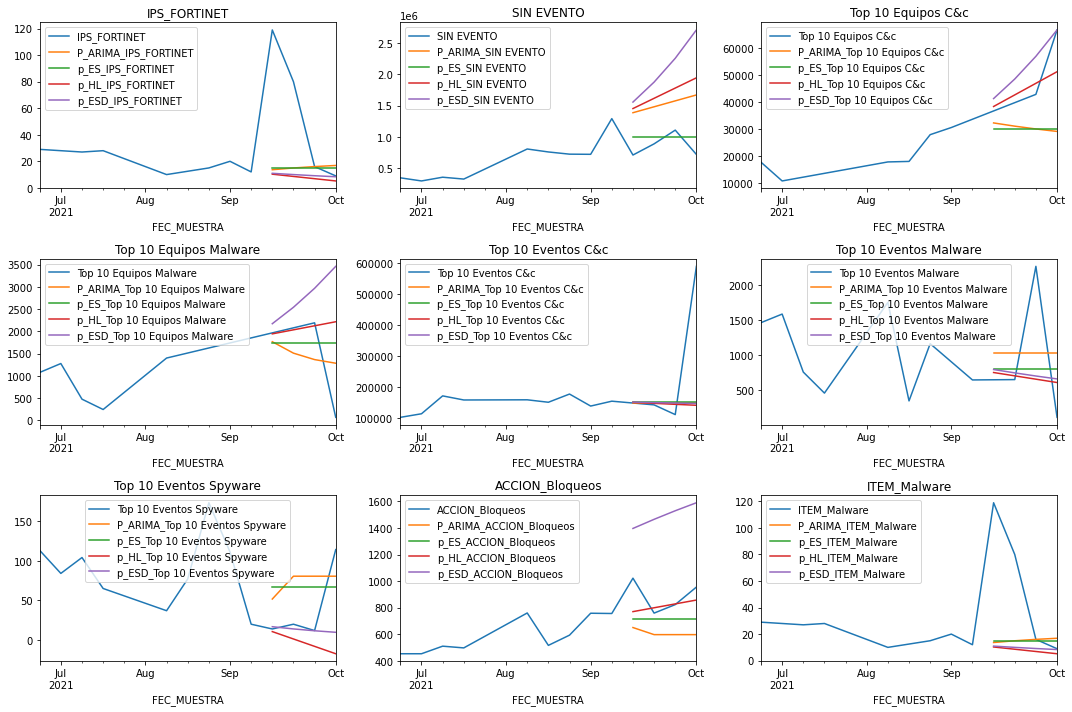

In [108]:
fig, axs = plt.subplots(3, 3 ,figsize=(15,10))
i=0
for col in grupos:
    dfDesEvento_T[[col]].plot(ax=axs[i//3,i%3])    
    axs[i//3,i%3].title.set_text(col)
    for model in prefix:
        dfDesEvento_T[[model+col]].plot(ax=axs[i//3,i%3])
    axs[i//3,i%3].legend(prop={'size':10})
    i=i+1
fig.tight_layout()

### Entrega de resultados

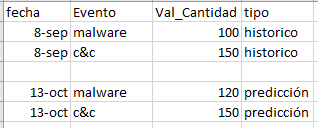

##  Pronosticos futuros

In [278]:
ind_P = pd.date_range(fechaMaxima, periods = 5, freq ='W-WED', name='FEC_MUESTRA')[1:]

In [279]:
ind_P

DatetimeIndex(['2021-10-13', '2021-10-20', '2021-10-27', '2021-11-03'], dtype='datetime64[ns]', name='FEC_MUESTRA', freq='W-WED')

In [280]:
dfResultado=pd.DataFrame(columns=colMetodos, index=ind_P)

In [281]:
dfResultado['SERIE']=np.nan

In [282]:
#dfResultado=dfResultado.reset_index()

In [283]:
dfResultado

,HL,ARIMA,ES,ESD,SERIE
FEC_MUESTRA,,,,,
2021-10-13,NaN,NaN,NaN,NaN,NaN
2021-10-20,NaN,NaN,NaN,NaN,NaN
2021-10-27,NaN,NaN,NaN,NaN,NaN
2021-11-03,NaN,NaN,NaN,NaN,NaN


In [284]:
dfResultadoFinal=dfResultado.copy()
for col in grupos:     
    #model AutoARIMA
    modelAutoARIMA=auto_arima(dfDesEvento_T[col],trace=False)
    modelAutoARIMA.fit(dfDesEvento_T[col])
    tf=pd.DataFrame(modelAutoARIMA.predict(n_periods = 4), index=ind_P, columns=['ARIMA'])
    modelSM = SimpleExpSmoothing(dfDesEvento_T[col])    
    P_modelSM=modelSM.fit(smoothing_level=.5).forecast(4)
    tf['ES']=P_modelSM
    #Holt
    modelHl = Holt(dfDesEvento_T[col])
    P_modelHl=modelHl.fit(optimized=True).forecast(4)    
    tf['HL']=P_modelHl    
    #ES tend
    modelESD=ExponentialSmoothing(dfDesEvento_T[col], trend='mul', seasonal=None, damped=True)
    P_modelESD=modelESD.fit().forecast(4)
    tf['ESD']=P_modelESD    
    #serie
    tf['SERIE']=col
    dfResultadoFinal=dfResultadoFinal.append(tf)
    

In [285]:
dfResultadoFinal=dfResultadoFinal[dfResultadoFinal['SERIE'].notnull()]

In [286]:
dfResultadoFinal.reset_index(inplace=True)

In [287]:
dfResultadoFinal

,FEC_MUESTRA,HL,ARIMA,ES,ESD,SERIE
0,2021-10-13,40.996,23.439,26.850,48.444,IPS_FORTINET
1,2021-10-20,42.425,29.180,26.850,51.159,IPS_FORTINET
2,2021-10-27,43.853,29.180,26.850,54.001,IPS_FORTINET
3,2021-11-03,45.282,29.180,26.850,56.975,IPS_FORTINET
4,2021-10-13,895219.169,1065503.676,853614.222,935305.546,SIN EVENTO
5,2021-10-20,870316.439,1093653.698,853614.222,966474.353,SIN EVENTO
6,2021-10-27,845413.709,999808.733,853614.222,998354.522,SIN EVENTO
7,2021-11-03,820510.979,1190503.729,853614.222,1030951.657,SIN EVENTO
8,2021-10-13,70377.509,76576.076,53083.896,68124.031,Top 10 Equipos C&c
9,2021-10-20,80708.433,86596.151,53083.896,79937.253,Top 10 Equipos C&c


In [288]:
# seleccionar mejor resultado
dfResultadoFinal['VAL_CANTIDAD']=0
dfResultadoFinal['metodo']=np.nan
for ind,row in dfResultadoFinal.iterrows():
    #print(ind)
    met=df_error.loc[row['SERIE'],'seleccion']
    #print(met)
    dfResultadoFinal.loc[ind,'metodo']=met
    dfResultadoFinal.loc[ind,'VAL_CANTIDAD']=dfResultadoFinal.loc[ind,met]
    #dfResultadoFinal

In [289]:
dfResultadoFinal

,FEC_MUESTRA,HL,ARIMA,ES,ESD,SERIE,VAL_CANTIDAD,metodo
0,2021-10-13,40.996,23.439,26.850,48.444,IPS_FORTINET,48.444,ESD
1,2021-10-20,42.425,29.180,26.850,51.159,IPS_FORTINET,51.159,ESD
2,2021-10-27,43.853,29.180,26.850,54.001,IPS_FORTINET,54.001,ESD
3,2021-11-03,45.282,29.180,26.850,56.975,IPS_FORTINET,56.975,ESD
4,2021-10-13,895219.169,1065503.676,853614.222,935305.546,SIN EVENTO,853614.222,ES
5,2021-10-20,870316.439,1093653.698,853614.222,966474.353,SIN EVENTO,853614.222,ES
6,2021-10-27,845413.709,999808.733,853614.222,998354.522,SIN EVENTO,853614.222,ES
7,2021-11-03,820510.979,1190503.729,853614.222,1030951.657,SIN EVENTO,853614.222,ES
8,2021-10-13,70377.509,76576.076,53083.896,68124.031,Top 10 Equipos C&c,70377.509,HL
9,2021-10-20,80708.433,86596.151,53083.896,79937.253,Top 10 Equipos C&c,80708.433,HL


In [290]:
formato_envio_pred=dfResultadoFinal[['FEC_MUESTRA','SERIE','VAL_CANTIDAD']]
formato_envio_pred['tipo']='pred'

In [291]:
formato_envio_pred

,FEC_MUESTRA,SERIE,VAL_CANTIDAD,tipo
0,2021-10-13,IPS_FORTINET,48.444,pred
1,2021-10-20,IPS_FORTINET,51.159,pred
2,2021-10-27,IPS_FORTINET,54.001,pred
3,2021-11-03,IPS_FORTINET,56.975,pred
4,2021-10-13,SIN EVENTO,853614.222,pred
5,2021-10-20,SIN EVENTO,853614.222,pred
6,2021-10-27,SIN EVENTO,853614.222,pred
7,2021-11-03,SIN EVENTO,853614.222,pred
8,2021-10-13,Top 10 Equipos C&c,70377.509,pred
9,2021-10-20,Top 10 Equipos C&c,80708.433,pred


### Formato envío

In [292]:
grupos

Index(['IPS_FORTINET', 'SIN EVENTO', 'Top 10 Equipos C&c',
       'Top 10 Equipos Malware', 'Top 10 Eventos C&c',
       'Top 10 Eventos Malware', 'Top 10 Eventos Spyware', 'ACCION_Bloqueos',
       'ITEM_Malware'],
      dtype='object', name='DES_EVENTO')

In [293]:
dfDesEvento_T[grupos]

DES_EVENTO,IPS_FORTINET,SIN EVENTO,Top 10 Equipos C&c,Top 10 Equipos Malware,Top 10 Eventos C&c,Top 10 Eventos Malware,Top 10 Eventos Spyware,ACCION_Bloqueos,ITEM_Malware
FEC_MUESTRA,,,,,,,,,
2021-06-30,29.000,342881.000,17635.000,1077.000,101761.000,1461.000,113.000,453.000,29.000
2021-07-07,28.000,293065.000,10705.000,1277.000,113314.000,1583.000,84.000,453.000,28.000
2021-07-14,27.000,352835.000,12111.600,477.000,171081.000,758.000,104.000,510.000,27.000
2021-07-21,28.000,323082.000,13518.200,245.000,157856.000,459.000,65.000,497.000,28.000
2021-07-28,22.000,483651.667,14924.800,630.000,158044.000,889.000,55.667,584.667,22.000
2021-08-04,16.000,644221.333,16331.400,1015.000,158232.000,1319.000,46.333,672.333,16.000
2021-08-11,10.000,804791.000,17738.000,1400.000,158420.000,1749.000,37.000,760.000,10.000
2021-08-18,12.500,757370.000,17927.000,1513.000,150511.000,348.000,77.000,516.000,12.500
2021-08-25,15.000,722115.000,27825.000,1626.000,176998.000,1162.000,173.000,593.000,15.000


In [294]:
formato_envio_hist=dfDesEvento_T[grupos].reset_index().melt(id_vars=['FEC_MUESTRA'],var_name='SERIE', value_name='VAL_CANTIDAD')

In [295]:
formato_envio_hist['tipo']='hist'

In [296]:
formato_envio_hist

,FEC_MUESTRA,SERIE,VAL_CANTIDAD,tipo
0,2021-06-30,IPS_FORTINET,29.000,hist
1,2021-07-07,IPS_FORTINET,28.000,hist
2,2021-07-14,IPS_FORTINET,27.000,hist
3,2021-07-21,IPS_FORTINET,28.000,hist
4,2021-07-28,IPS_FORTINET,22.000,hist
...,...,...,...,...
130,2021-09-08,ITEM_Malware,12.000,hist
131,2021-09-15,ITEM_Malware,119.000,hist
132,2021-09-22,ITEM_Malware,80.000,hist
133,2021-09-29,ITEM_Malware,16.000,hist


In [297]:
formato_envio=formato_envio_hist.append(formato_envio_pred)

In [298]:
formato_envio

,FEC_MUESTRA,SERIE,VAL_CANTIDAD,tipo
0,2021-06-30,IPS_FORTINET,29.000,hist
1,2021-07-07,IPS_FORTINET,28.000,hist
2,2021-07-14,IPS_FORTINET,27.000,hist
3,2021-07-21,IPS_FORTINET,28.000,hist
4,2021-07-28,IPS_FORTINET,22.000,hist
...,...,...,...,...
31,2021-11-03,ACCION_Bloqueos,1068.960,pred
32,2021-10-13,ITEM_Malware,48.444,pred
33,2021-10-20,ITEM_Malware,51.159,pred
34,2021-10-27,ITEM_Malware,54.001,pred


In [309]:
fechaMinPron=formato_envio_pred['FEC_MUESTRA'].min()
fechaMaxPron=formato_envio_pred['FEC_MUESTRA'].max()
nomFile='Eco_seg_'+fechaMinPron.strftime("%Y%m%d")+'_'+fechaMaxPron.strftime("%Y%m%d")

In [310]:
formato_envio.to_csv(nomFile+'.csv',index=False)